In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
import cv2
import pixiedust
from PIL import Image

Pixiedust database opened successfully


In [2]:
orgs = glob.glob("training_test_data/data3voc/train/image/*.jpg")
masks = glob.glob("training_test_data/data3voc/train/mask/*.png")


In [3]:
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    im = cv2.imread(image, 0)
    resized = cv2.resize(im, (512,512))
    imgs_list.append(resized)
    #imgs_list.append(np.array(Image.open(image).resize((256, 256))))
    
    im_mask = cv2.imread(mask, 0)
    resized_mask = cv2.resize(im_mask, (512,512))
    masks_list.append(resized_mask)

    


imgs_np = np.asarray(imgs_list)
print(imgs_np.shape)
masks_np = np.asarray(masks_list)
print(masks_np.shape)

(27, 512, 512)
(27, 512, 512)


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

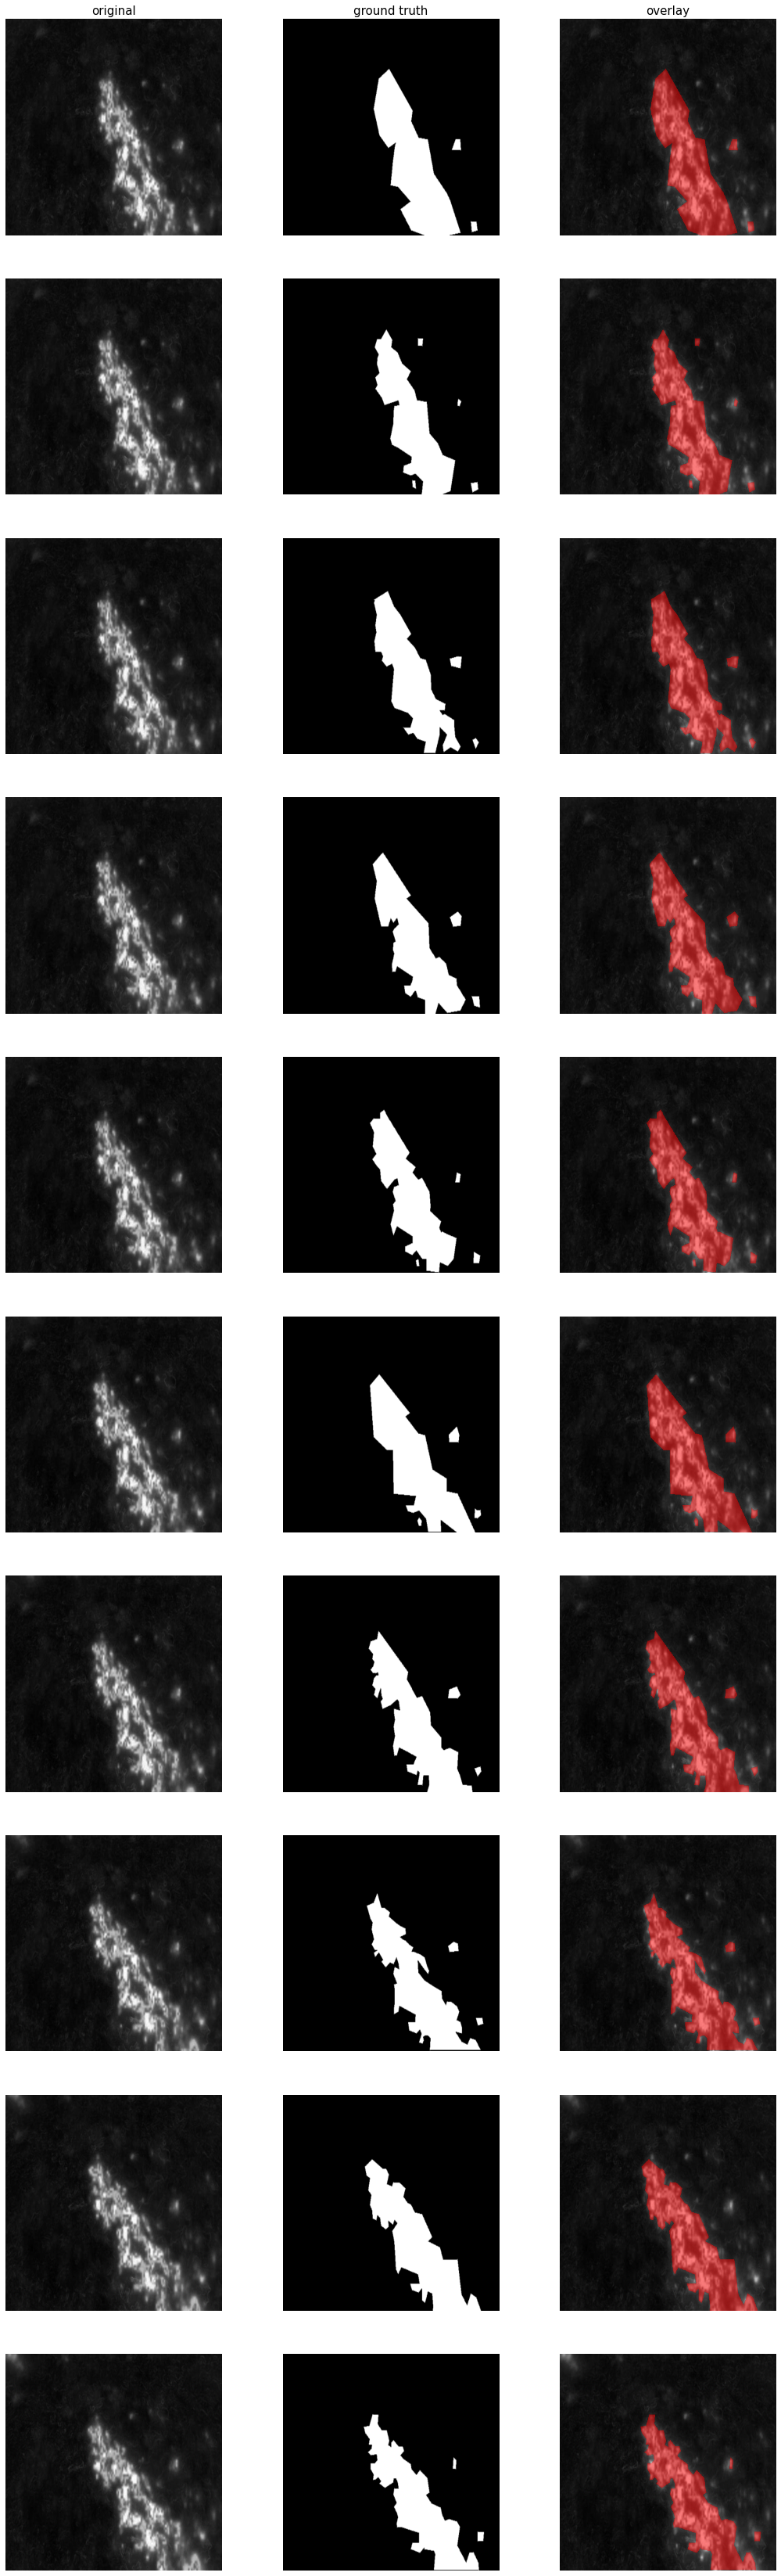

In [4]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)

In [5]:
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)


In [6]:
print(x.shape, y.shape)

(27, 512, 512, 1) (27, 512, 512, 1)


In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (13, 512, 512, 1)
y_train:  (13, 512, 512, 1)
x_val:  (14, 512, 512, 1)
y_val:  (14, 512, 512, 1)


## Prepare train generator with data augmentation

In [8]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


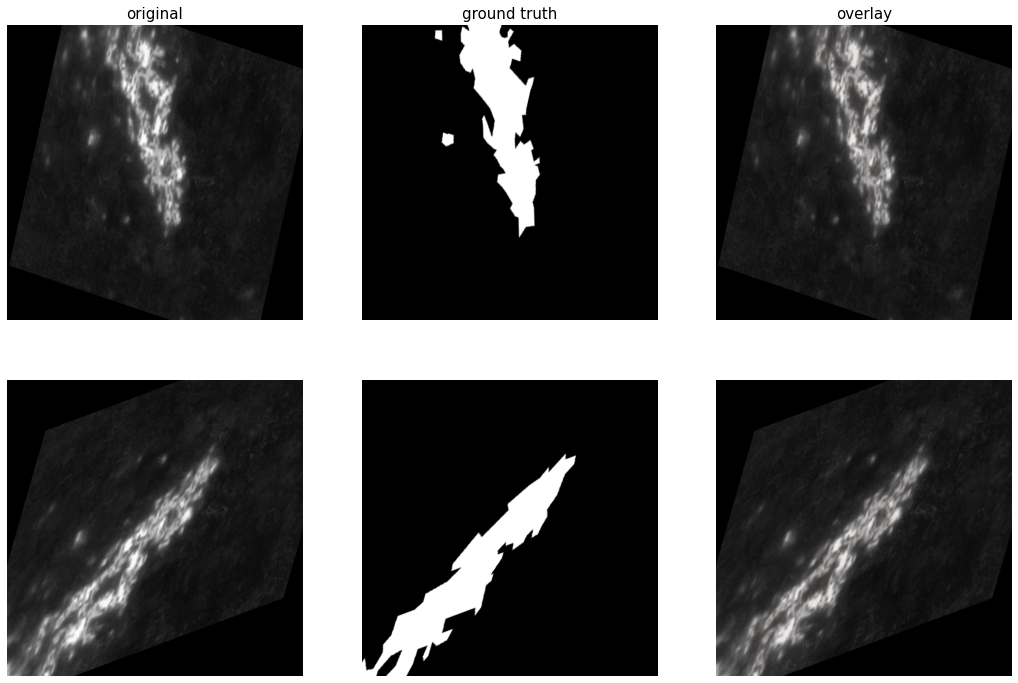

In [9]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

### Initialize network

In [10]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

### Compile and train

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [12]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.5),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)


In [13]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


KeyboardInterrupt: 

### Plot training history

In [ ]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

### Perform inference with trained model

In [14]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


%%pixie_debugger

from keras_unet.utils import plot_imgs
import pixiedust
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)



### testing model on image input

In [15]:
def parse(image):
    ### convert from single channel to 3 channel
    image = np.squeeze(image)
    image = [image, image, image]
    image = np.transpose(image, (1, 2, 0))
    return image

In [20]:
orig_img = cv2.imread("training_test_data/fire0.JPG", 0)
orig_img = cv2.resize(orig_img, (512, 512))/255.0

In [21]:
img_output = model.predict(np.expand_dims(orig_img, axis=0))[0] > 0.15

### visualization of binary ouput

In [22]:
results = ( parse(img_output) * 255.0).astype("uint8") 

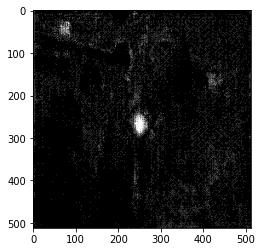

In [23]:
fig, axes = plt.subplots()

im = axes.imshow(results)